##A20000755,Mohamed Elnakshbandy

##A20000847,Mohamed Yasser Saad

In [6]:
# Data manipulation
import numpy as np
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import re
import random

# Data visualizations
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import missingno as msno

# Stopwords
import nltk
from nltk.corpus import stopwords

# Machine learning
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Jupyter notebook widgets
import ipywidgets as widgets

# Constant colour palette
colors = sns.color_palette('pastel')

# Display graphs inline
%matplotlib inline

In [7]:
# Reading in the TSV files:
users_df =  pd.read_csv('users.tsv', sep='\t', encoding='utf-8', low_memory=False)
jobs_df = pd.read_csv('jobs.tsv', sep='\t', encoding='utf-8', on_bad_lines='skip', low_memory=False)
original_jobs_df = jobs_df.copy()
users_history_df = pd.read_csv('user_history.tsv', sep='\t', encoding='utf-8', low_memory=False)

# Total number of entries for each file:
print("Total rows per dataset:")
print("-------------------------------")
print("users_df: \t \t" + str(len(users_df)))
print("jobs_df:  \t \t" + str(len(jobs_df)))
print("users_history_df: \t" + str(len(users_history_df)))

Total rows per dataset:
-------------------------------
users_df: 	 	389708
jobs_df:  	 	1040750
users_history_df: 	1753901


In [8]:
# Dataset containing the different users looking for jobs
users_df.head(2)

UserID       City State Country ZipCode   DegreeType         Major  \
0      47  Paramount    CA      US   90723  High School           NaN   
1      72    La Mesa    CA      US   91941     Master's  Anthropology   

        GraduationDate  WorkHistoryCount  TotalYearsExperience  \
0  1999-06-01 00:00:00                 3                  10.0   
1  2011-01-01 00:00:00                10                   8.0   

  CurrentlyEmployed ManagedOthers  ManagedHowMany  
0               Yes            No               0  
1               Yes            No               0

In [9]:
# Dataset containing the different job openings
jobs_df.head(2)


JobID                             Title  \
0      1  Security Engineer/Technical Lead   
1      4         SAP Business Analyst / WM   

                                         Description  \
0  <p>Security Clearance Required:&nbsp; Top Secr...   
1  <strong>NO Corp. to Corp resumes&nbsp;are bein...   

                                        Requirements        City State  \
0  <p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...  Washington    DC   
1  <p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...   Charlotte    NC   

  Country   Zip5  
0      US  20531  
1      US  28217

In [10]:
# Dataset containing the job history of the users.
users_history_df.head(2)

UserID  Sequence                                           JobTitle
0      47         1  National Space Communication Programs-Special ...
1      47         2                                  Detention Officer

In [14]:
# Drop unnecessary columns from the users_df
users_df.drop('ZipCode', inplace=True, axis=1)
users_df.drop('GraduationDate', inplace=True, axis=1)

# Drop unnecessary columns from the jobs_df
jobs_df.drop('Zip5', inplace=True, axis=1)
jobs_df.drop('Requirements', inplace=True, axis=1)

In [15]:
# Remove all digits from "Country" column
jobs_df = jobs_df[~jobs_df.Country.str.contains(r'\d', na=False)]

In [16]:
# Remove rows with null values where null values should not be
users_df = users_df.dropna(axis=0, subset=['CurrentlyEmployed', 'TotalYearsExperience', 'Major'])
jobs_df = jobs_df.dropna(axis=0, subset=['Title', 'City', 'State'])
users_history_df = users_history_df.dropna(axis=0, subset=['JobTitle'])

In [17]:
# Add the title to the job description
jobs_df['Description'] = jobs_df['Description'].fillna('')
jobs_df['Description'] = jobs_df['Title'] + ": " + jobs_df['Description']

In [18]:
users_df['TotalYearsExperience'] = users_df['TotalYearsExperience'].astype(dtype='int')

In [19]:
# See the number of unique countries listed for the job openings:
print(jobs_df.Country.value_counts())
print("Num countries: " + str(jobs_df['Country'].nunique()))
percentage_US = len(jobs_df[(jobs_df['Country'] == 'US')])/len(jobs_df)*100

US    1039396
AF        522
CZ        177
MX         87
AU         76
AT         75
TR         58
HU         41
RU         40
SK         33
ZA         32
JP         25
BR         23
MT         14
LU         10
HR          8
BT          8
FI          7
PH          6
BJ          6
DJ          6
LT          5
CL          5
HK          5
UM          4
BG          4
UY          4
KR          4
PA          4
PE          3
GE          3
GI          3
NZ          3
KE          2
ID          2
UZ          2
AO          2
TW          2
UA          2
ZW          2
VN          2
SI          2
TT          1
EH          1
VA          1
CR          1
LV          1
BM          1
UG          1
EE          1
CO          1
AW          1
BS          1
DZ          1
PK          1
TL          1
FX          1
SR          1
NG          1
Name: Country, dtype: int64
Num countries: 59


In [21]:
# Only look at jobs and users from the US
jobs_df = jobs_df.loc[jobs_df['Country'] == "US"]
users_df = users_df.loc[users_df['Country'] == "US"]

# Drop the "Country" column as it is unnecessary
users_df.drop('Country', inplace=True, axis=1)
jobs_df.drop('Country', inplace=True, axis=1)

In [22]:
users_df.loc[users_df['UserID'] == 6279]

UserID            City State  DegreeType                        Major  \
266    6279  Fredericksburg    VA  Bachelor's  History and Social Sciences   

     WorkHistoryCount  TotalYearsExperience CurrentlyEmployed ManagedOthers  \
266                 8                   112               Yes           Yes   

     ManagedHowMany  
266              50

In [23]:
# Remove users with more than 52 years of work experience 
users_df = users_df.loc[users_df['TotalYearsExperience'] <= 52]

In [24]:
print("Number of duplicate user ids in users_df: " + str(users_df.duplicated(subset='UserID').sum()))
print("Number of duplicate job ids in jobs_df: " + str(jobs_df.duplicated(subset='JobID').sum()))
print("Number of duplicate job and user ids in users_history_df: " + str(users_history_df.duplicated(subset=['JobTitle', 'UserID', 'Sequence']).sum()))

Number of duplicate user ids in users_df: 0
Number of duplicate job ids in jobs_df: 0
Number of duplicate job and user ids in users_history_df: 0


In [25]:
jobs_df['Description'].iat[0]

'Security Engineer/Technical Lead: <p>Security Clearance Required:&nbsp; Top Secret </p>\\r<p>Job Number: TMR-447</p>\\r<p>Location of Job:&nbsp; Washington, DC</p>\\r<p>TMR, Inc. is an Equal Employment Opportunity Company</p>\\r<p>For more job opportunities with TMR, visit our website <a href="http://www.tmrhq.com/">www.tmrhq.com</a></p>\\r<p>Send Resumes to HR@tmrhq2.com</p>\\r<p>&nbsp;</p>\\r<p>JOB SUMMARY:</p>\\r<p>&nbsp;</p>\\r<p>Leads the customer&rsquo;s overall Cyber Security strategy, formalizes service offerings consisted with ITIL best practices, and provides design and architecture support.</p>\\r<p>&nbsp;</p>\\r<ul>\\r    <li>Provide security design / architecture support for OJP&rsquo;s IT Security Division (ITSD) </li>\\r    <li>Leads the SECOPS team in the day to day OJP Security Operations support&nbsp; </li>\\r    <li>Provides direction when needed in a security incident or technical issues </li>\\r    <li>Works in concert with network operations on design /integratio

In [26]:
def clean_html(description):

    # Get rid of all <> tags
    new_description = re.sub('<[^<]+?>', '', description)

    # A list of all elements that must be taken out of the descriptions
    char_none_remove = ["&nbsp;", "\n", ",", ";", ".", "&"]
    char_space_remove = ["\\r", "(", ")", ",", ":", "-", "/"]

    for char in char_none_remove:
        new_description = new_description.replace(char, "")
    for char in char_space_remove:
        new_description = new_description.replace(char, " ")
    
    # Removing all 
    new_description = " ".join(new_description.split())
    return new_description.lower()

jobs_df['Description'] = jobs_df['Description'].astype(dtype='str').apply(clean_html)
jobs_df['Description'].iat[0]

'security engineer technical lead security clearance required top secret job number tmr 447 location of job washington dc tmr inc is an equal employment opportunity company for more job opportunities with tmr visit our website wwwtmrhqcom send resumes to hr@tmrhq2com job summary leads the customerrsquos overall cyber security strategy formalizes service offerings consisted with itil best practices and provides design and architecture support provide security design architecture support for ojprsquos it security division itsd leads the secops team in the day to day ojp security operations support provides direction when needed in a security incident or technical issues works in concert with network operations on design integration for best security posture supports business development functions including capture management proposal development and responses and other initiatives to include conferences trade shows webinars developing white papers and the like identifies resources and me

In [27]:
users_df.isna().sum()

UserID                  0
City                    0
State                   0
DegreeType              0
Major                   0
WorkHistoryCount        0
TotalYearsExperience    0
CurrentlyEmployed       0
ManagedOthers           0
ManagedHowMany          0
dtype: int64

In [28]:
jobs_df.isna().sum()

JobID          0
Title          0
Description    0
City           0
State          0
dtype: int64

In [29]:
users_history_df.isna().sum()

UserID      0
Sequence    0
JobTitle    0
dtype: int64

In [31]:
top_n_cities = 20

In [32]:
citywise_jobs = jobs_df.groupby(['City']).size().reset_index(name='CitywiseJobs')
citywise_users = users_df.groupby(['City']).size().reset_index(name='CitywiseUsers')
city_df = pd.merge(citywise_jobs, citywise_users, on='City', how='outer').sort_values('CitywiseJobs', ascending=False)
city_df = city_df.dropna()

figure = plt.figure(figsize=(13,4))

ax = figure.subplots()
 
# Plotting columns
ax = sns.barplot(x="City", y="CitywiseJobs",data=city_df.head(top_n_cities), color='paleturquoise', label="Job openings")
ax = sns.barplot(x="City", y="CitywiseUsers",data=city_df.head(top_n_cities), color='cornflowerblue', label="Job seekers")
 
# Renaming the axes
ax.set(xlabel="City", ylabel="Job openings and job seekers")
ax.set_title("Job openings and job seekers in the top 20 cities", fontsize='13')
ax.legend(loc='upper right', fontsize='13')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')
# Visualizing illustration
plt.show()

In [33]:
print(citywise_jobs.loc[citywise_jobs['City'] == "New York"]["CitywiseJobs"].tolist()[0])
print(citywise_users.loc[citywise_users['City'] == "New York"]["CitywiseUsers"].tolist()[0])

17442
1473


In [34]:
# Plotting total number of degree types
plt.figure(figsize=(10,4))
ax = sns.countplot(x='DegreeType', data=users_df,palette=colors)
ax.set_xticklabels(ax.get_xticklabels())
ax.set_title('Total number of different degree types')
plt.ylabel("Number of users")
plt.tight_layout()
plt.show()


In [35]:
# Dropdown menu to filter by state
def dropdown_menu(State="CA"):
    per_state_df =users_df.query("State == @State")
    plt.figure(figsize=(10,4))
    ax = sns.countplot(x='DegreeType', data=per_state_df,palette=colors)
    ax.set_xticklabels(ax.get_xticklabels())
    ax.set_title(f'Number of degrees in state {State}')
    plt.ylabel("Total number of users")
    plt.xlabel("Degree type")
    plt.tight_layout()
    plt.show()

states_list = users_df['State'].unique().tolist()
widgets.interact(dropdown_menu, State=states_list)

interactive(children=(Dropdown(description='State', options=('CA', 'NJ', 'NY', 'LA', 'SC', 'VT', 'VA', 'MO', '…

<function __main__.dropdown_menu(State='CA')>

In [36]:
# Plotting top 10 majors
majors_df = users_df.groupby('Major').size().reset_index(name='Majors').sort_values('Majors',ascending=False)[1:11]
majors_df = majors_df.query("Majors >= 10")
data = majors_df['Majors']
majors_labels = majors_df['Major']
plt.pie(data, labels = majors_labels, colors = colors, autopct='%.0f%%')
plt.title("Top 10 majors in the US")
plt.show()


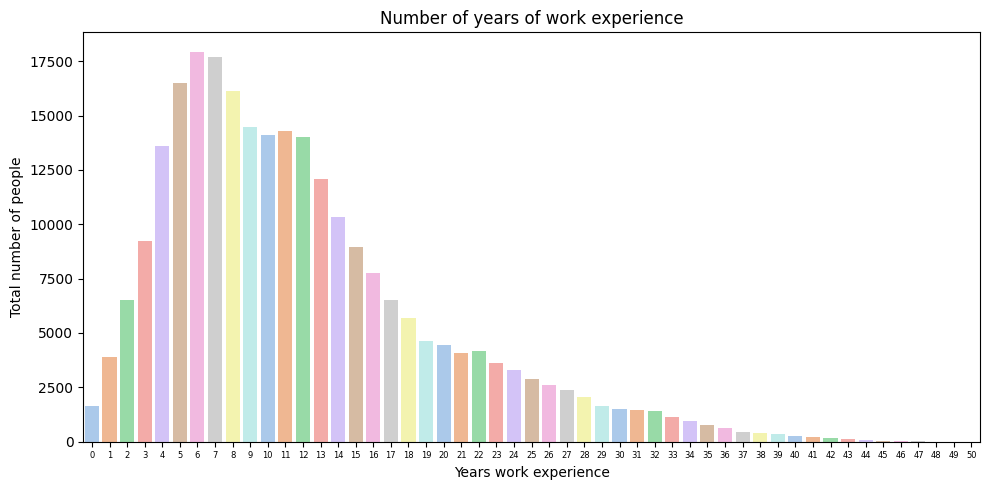

In [37]:
# Plotting the total amount of work experience
min_experience_df = users_df.copy()
min_experience_df = min_experience_df.dropna(axis=0, subset=['TotalYearsExperience'])
min_experience_df['TotalYearsExperience'] = min_experience_df['TotalYearsExperience'].astype(dtype='int')
exper = max(min_experience_df['TotalYearsExperience'])
min_experience_df = min_experience_df.query("TotalYearsExperience <= 52")
plt.figure(figsize=(10,5))
ax = sns.countplot(x='TotalYearsExperience', data=min_experience_df,palette=colors)
ax.set_xticklabels(ax.get_xticklabels())
ax.set_title('Number of years of work experience')
plt.ylabel("Total number of people")
plt.xlabel("Years work experience")
plt.xticks( fontsize=6) # Rotates X-Axis Ticks by 45-degrees
plt.tight_layout()
plt.show()


In [38]:
# Create tags for the bag
first_few_jobs = jobs_df.iloc[:5000]
first_few_jobs['tags'] = first_few_jobs['Title'] + ' ' + first_few_jobs['Description'] + ' ' + first_few_jobs['City'] + ' ' + first_few_jobs['State']

# Drop records with empty tags and dublicates
first_few_jobs.drop(first_few_jobs[first_few_jobs['tags']==''].index, inplace=True)
first_few_jobs.drop_duplicates(inplace=True)

# Add a fresh index to the dataframe, which we will later use when refering to items in the vector matrix
first_few_jobs['new_id'] = range(0, len(first_few_jobs))

# Create an empty DataFrame and extract the relevant columns
bag_df = pd.DataFrame()
bag_df = first_few_jobs[['new_id', 'JobID', 'Title', 'tags', 'City', 'State']]
first_few_jobs.drop('tags', inplace=True, axis=1)

# Display the data
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.expand_frame_repr', False)
bag_df.head(2)

new_id  JobID                             Title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 tags        City State
0       0      1  Security Engineer/Technical Lead  Security Engineer/Technical Lead security engineer technical lead security clearance required top secret job number tmr 447 location of job washington dc tmr inc is an equal employment opportunity company for more job opportunities with tmr visit our website wwwtmrhqcom send resumes to hr@tmrhq2com job summary leads the customerrsquos overall cyber security strategy formalizes service offerings consisted with itil best practices and provides design and architecture support provide security d...  Washington    DC
1       1      4         SAP Business Analyst / WM  SAP Business Analyst / WM sap business analyst wm no corp to corp resumesare being considered for this ldquodirect hire" permanent position h 1b transfers are available for qualified candidates with 5+ years of wm experience sap wm warehouse management sr business analyst positionrsquos location is the charlotte nc metro area we are currently seeking a senior sap business analyst with a minimum of 5 years of sap wm warehouse management experience for a "direct hire opportunity" in the charlo...   Charlotte    NC

(0.0, 9778.0)

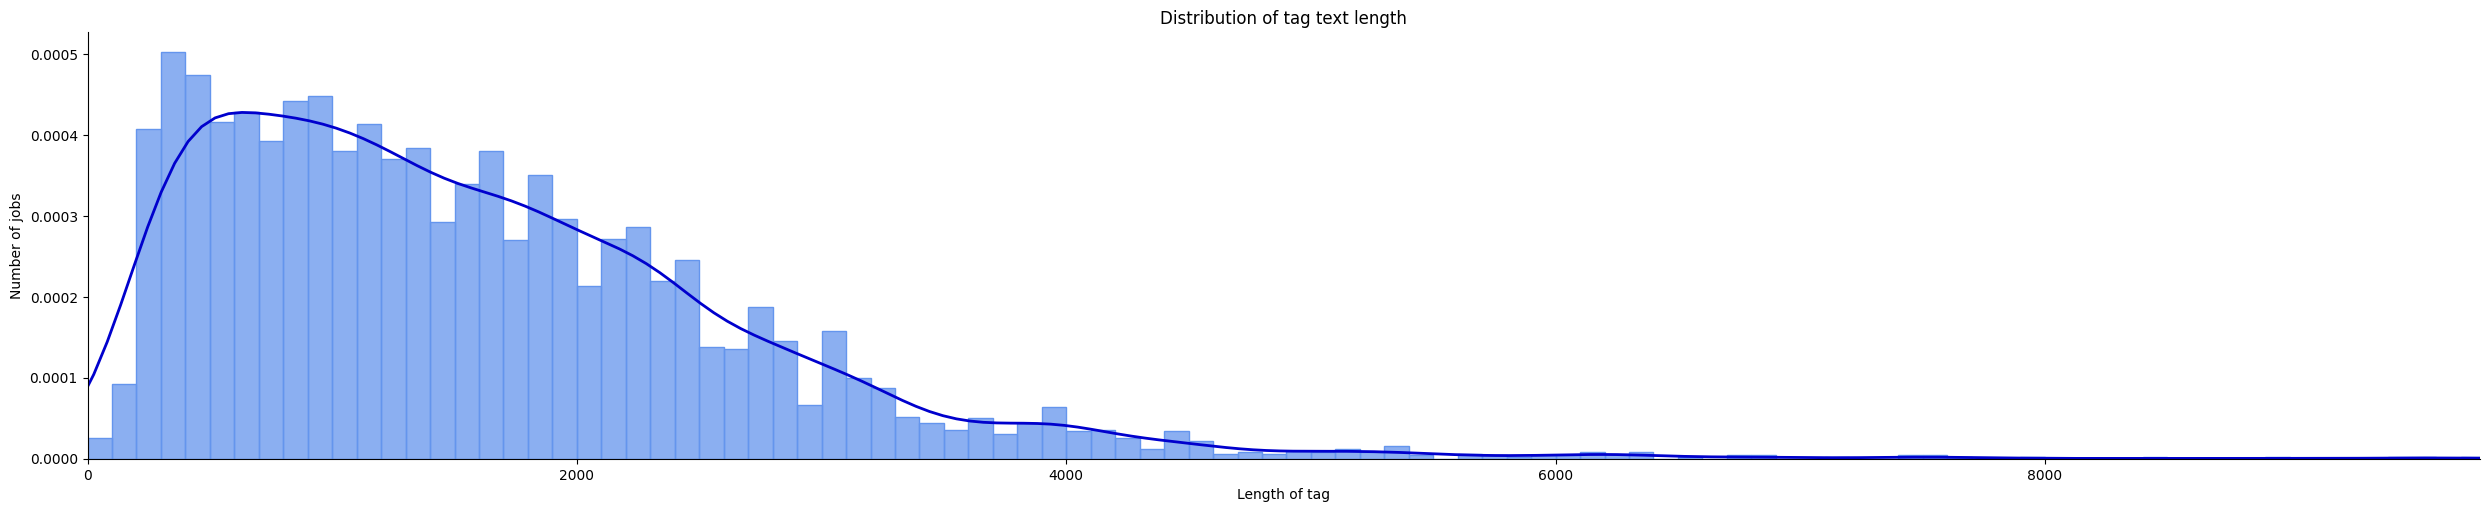

In [39]:
# Add the tag length to the jobs df
bag_df['tag_len'] = bag_df['tags'].apply(lambda x: len(x))
bag_df = bag_df.dropna()

# Illustrate the tag text length
ax = sns.displot(data=bag_df, bins=list(range(0, 10000, 100)), height=5, x='tag_len', aspect=5, kde=False, stat='density', color='cornflowerblue', edgecolor='cornflowerblue')
sns.kdeplot(data=bag_df, x="tag_len", color='mediumblue', ax=ax, linewidth=2)
plt.title('Distribution of tag text length')
plt.xlabel('Length of tag')
plt.ylabel('Number of jobs')
plt.xlim([0, max(bag_df['tag_len'])])

In [40]:
# Set a custom stop list using the nltk package
stop = list(stopwords.words('english'))

# Display some of the stop words
print("Number of stopwords: " + str(len(stop)))
stop[100:105]

Number of stopwords: 179


['here', 'there', 'when', 'where', 'why']

In [41]:
# Create the tfid vectorizer
tfidf =  TfidfVectorizer(max_features=7000, analyzer = 'word', stop_words=set(stop))
tfidf

TfidfVectorizer(max_features=7000,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [42]:
# Create the feature vector
vectorized_data = tfidf.fit_transform(bag_df['tags'])
feature_vector = pd.DataFrame(vectorized_data.toarray(), index=bag_df['tags'].index.tolist())
print(feature_vector)

      0     1     2     3     4     5     6     7     8     9     ...  6990  6991  6992  6993  6994  6995  6996  6997  6998  6999
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
4998   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   

In [43]:
print(tfidf.get_feature_names_out()[2000:2010])

['dispute' 'disputes' 'distance' 'distinguish' 'distribute' 'distributed'
 'distributes' 'distributing' 'distribution' 'distributor']


In [44]:
# Dimension reduction using SVD
svd = TruncatedSVD(n_components=3000)
reduced_jobs = svd.fit_transform(feature_vector)

In [45]:
# Compute the cosine similarity matrix
similarity = cosine_similarity(reduced_jobs)
similarity

array([[ 1.00000000e+00,  8.07476487e-02,  4.05853806e-02, ...,
         4.57538981e-02, -1.79205583e-04,  2.28204600e-03],
       [ 8.07476487e-02,  1.00000000e+00,  1.03329064e-02, ...,
         5.20741486e-02,  2.75021908e-03,  3.84262946e-02],
       [ 4.05853806e-02,  1.03329064e-02,  1.00000000e+00, ...,
         8.14568548e-03,  1.32399437e-02, -5.21251366e-04],
       ...,
       [ 4.57538981e-02,  5.20741486e-02,  8.14568548e-03, ...,
         1.00000000e+00,  4.96886995e-02,  2.97924010e-01],
       [-1.79205583e-04,  2.75021908e-03,  1.32399437e-02, ...,
         4.96886995e-02,  1.00000000e+00,  2.67243803e-01],
       [ 2.28204600e-03,  3.84262946e-02, -5.21251366e-04, ...,
         2.97924010e-01,  2.67243803e-01,  1.00000000e+00]])

In [46]:
# Create a function that takes in job title as input and returns a list of the most similar jobs
def get_recommendations(title, n, bag_df, similarity):

    # Set cosine similarity
    cosine_sim=similarity

    # get the index of the job that matches the title
    bag_without_title = bag_df.copy()
    job_index = bag_without_title[bag_without_title.Title==title].new_id.values[0]
    # print(len(cosine_sim))
    # get the pairwsie similarity scores of all jobs with that job and sort the jobs based on the similarity scores
    sim_scores_all = sorted(list(enumerate(cosine_sim[job_index])), key=lambda x: x[1], reverse=True)
    
    # checks if recommendations are limited
    if n > 0:
        sim_scores_all = sim_scores_all[1:n+1]
        
    # get the job indices of the top similar jobs
    job_indices = [i[0] for i in sim_scores_all]
    scores = [i[1] for i in sim_scores_all]

    top_name = bag_without_title.iloc[job_indices[0]]['Title']
    
    new_id_list = []
    title_list = []
    city_list = []
    state_list = []
    score_list = []
    for i in range(len(job_indices)):
        new_id_list.append(bag_without_title.iloc[job_indices[i]]['new_id'])
        title_list.append(bag_without_title.iloc[job_indices[i]]['Title'] + " (" + bag_without_title.iloc[job_indices[i]]['City'] + ")")
        city_list.append(bag_without_title.iloc[job_indices[i]]['City'])
        state_list.append(bag_without_title.iloc[job_indices[i]]['State'])
        score_list.append(scores[i])

    top_n_df = pd.DataFrame({'new_id': new_id_list, 'Title': title_list, 'City': city_list, 'State': state_list, 'Score': score_list})
    del new_id_list, title_list, city_list, state_list , score_list
    return top_n_df, sim_scores_all, top_name

In [47]:
# Visualize the results
def show_results(job_name, top_titles_df, number_of_recommendations, city):
    fix, ax = plt.subplots(figsize=(14, 4))
    sns.barplot(data=top_titles_df, y='Title', x= 'Score', color='blue', palette="pastel")
    plt.xlim((0,1))
    plt.title(f'Top {number_of_recommendations} recommendations for {job_name}  ({city})')
    pct_values = ['{:.4}'.format(elm) for elm in list(top_titles_df['Score'])]
    pct_values = pct_values[:-1]
    ax.bar_label(container=ax.containers[0], labels=pct_values, size=12)
    return top_titles_df

In [48]:
# Calling get_recommendations and show_results
def show_top_n(job_name, number_of_recommendations, bag_df, similarity):
    city_list = bag_df.loc[bag_df['Title'] == job_name]['City'].tolist()
    state = bag_df.loc[bag_df['Title'] == job_name]['State'].tolist()[0]
    top_titles_df, sim_score_all, top_name = get_recommendations(job_name, number_of_recommendations + 1, bag_df, similarity)
    return show_results(job_name, top_titles_df, number_of_recommendations, city_list[0])


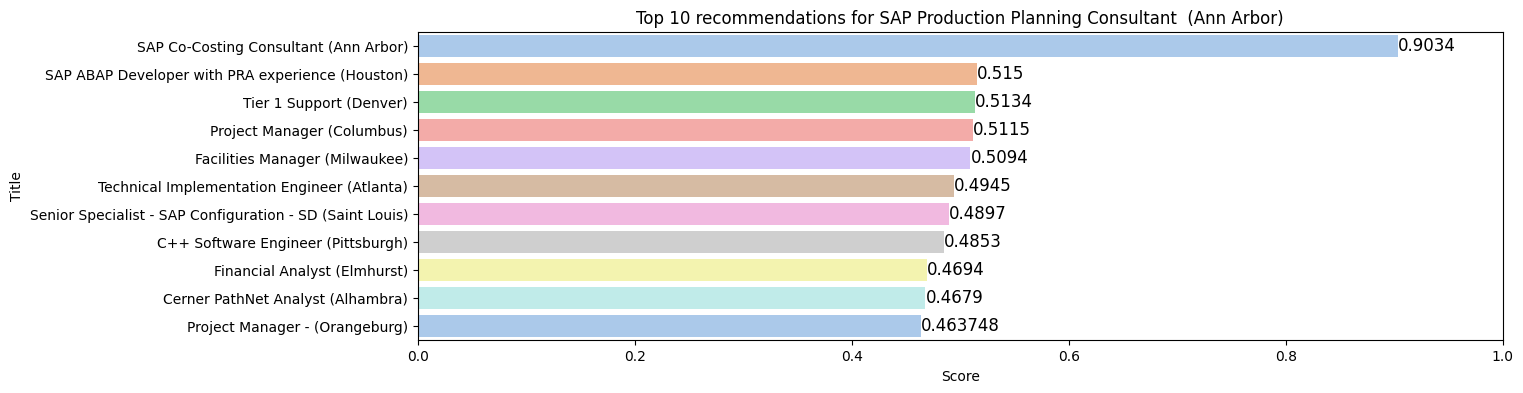

In [49]:
job_title = "SAP Production Planning Consultant"
top_titles_df = show_top_n(job_title, 10, bag_df, similarity)

In [50]:
# Comparing the job description with the top-rated recommended job
city = original_jobs_df.loc[original_jobs_df['Title'] == job_title]['City'].tolist()[0]
desc = original_jobs_df.loc[original_jobs_df['Title'] == job_title]['Description'].tolist()[0]

print(job_title + ": ")
print("City: " + city)
print("Description: " + desc)

number_of_recommendations = 1
top_titles_df, sim_score_all, suggested_id = get_recommendations(job_title, number_of_recommendations + 1, bag_df, similarity)

top_titles_df

job_recommended_title = suggested_id
city = original_jobs_df.loc[original_jobs_df['Title'] == job_recommended_title]['City'].tolist()[0]
desc = original_jobs_df.loc[original_jobs_df['Title'] == job_recommended_title]['Description'].tolist()[0]

print()
print(job_recommended_title + ": ")
print("City: " + city)
print("Description: " + desc)

SAP Production Planning Consultant: 
City: Ann Arbor
Description: <b>Responsibilities:</b> Our client is seeking consultants to support a nationwide SAP implementation. The primary function of this role is providing production support for end users during deployment. There will also be some configuration and deployment support at times as well.\r\n\r\nKforce (Nasdaq:KFRC) is a professional staffing and solutions firm providing flexible and permanent staffing solutions in the skill areas of technology, finance & accounting, clinical research and healthcare. Backed by approximately our associates and consultants on assignment, Kforce is committed to "Great People = Great Results" for our valued clients and candidates. Kforce operates with 65 offices located throughout the United States and two offices in the Philippines.\r\n\r\nJob Ref#: 2312~EQG~1138726T1~99

SAP Co-Costing Consultant: 
City: Ann Arbor
Description: <b>Responsibilities:</b> Our client is seeking consultants in Ann Arbor,

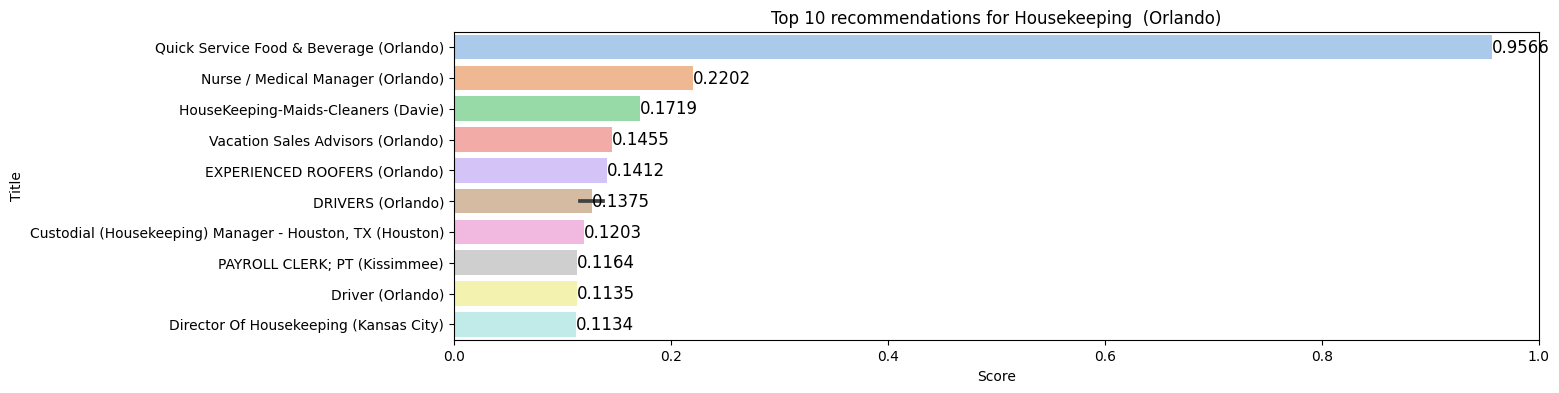

In [51]:
job_title = "Housekeeping"
top_titles_df = show_top_n(job_title, 10, bag_df, similarity)

In [52]:
city = original_jobs_df.loc[original_jobs_df['Title'] == job_title]['City'].tolist()[0]
desc = original_jobs_df.loc[original_jobs_df['Title'] == job_title]['Description'].tolist()[0]

print(job_title + ": ")
print("City: " + city)
print("Description: " + desc)

number_of_recommendations = 1
top_titles_df, sim_score_all, suggested_id = get_recommendations(job_title, number_of_recommendations + 1, bag_df, similarity)

top_titles_df

job_suggested_title = suggested_id
city = original_jobs_df.loc[original_jobs_df['Title'] == job_suggested_title]['City'].tolist()[0]
desc = original_jobs_df.loc[original_jobs_df['Title'] == job_suggested_title]['Description'].tolist()[0]

print()
print(job_suggested_title + ": ")
print("City: " + city)
print("Description: " + desc)

Housekeeping: 
City: Orlando
Description: I make  sure every part of their day is magical. I am Disney. Dreams. That?s what you?ll find at the Walt Disney World? Resort. There are many guest service and entertainment roles in which our cast members bring Disney dreams to life. From our enchanted Theme Parks and world-class Resort Hotels to our spectacular shows and beloved characters, Walt Disney World Resort cast members have a world of opportunity and take pride in turning dreams into realities. Opportunities currently available: Housekeeping ? Bus Drivers ? Custodial Recreation ? Stewards ? Culinary ? Lifeguards Quick Service Food and Beverage Character Look-alike Performers For more information and to apply online, visit WaltDisneyWorld.jobs/NowHiring Apply online today! EOE ? Drawing Creativity from Diversity ? Disney <br><br>Source - Orlando Sentinel

Quick Service Food & Beverage: 
City: Orlando
Description: I love making his day a little sweeter.  I am Disney.  Dreams. That's w

In [53]:
users_history_df.head(1)

UserID  Sequence                                                          JobTitle
0      47         1  National Space Communication Programs-Special Program Supervisor

In [54]:
# Drop the sequence number for the user_history_df as its not important otehr tahn to job if the job is a duplicate. 
users_history_df.drop('Sequence', inplace=True, axis=1)

In [55]:
# import random

# # Create a list of available userID's from the users_history_df dataset
users_history_list = users_history_df["UserID"].unique().tolist()

# # Check which users are in the dataset
available_users = users_df["UserID"].unique().tolist()

# Only take ID's that are in both users_df and users_history_df
available_users.extend(users_history_list)


# available_ids = set(i for i in history_list if history_list.count(i) > 1)
# len(available_ids)
# res = [i for i in available_users if i in users_history_list]
userID_list = random.sample(available_users, 20)

x = widgets.Dropdown(options=userID_list)
y = widgets.Dropdown(options=[' - '])

def change_x(*args):
    y.index = None
    y.options=[1, 2, 3]
    
x.observe(change_x, 'value')
widgets.HBox([x])

In [58]:
userID = x.value
print(userID)

1166575


In [59]:
# Create the bag-of-words and add the users past expereince to the bag of words

bag_userID = bag_df.copy()
city = users_df.loc[users_df['UserID'] == userID]['City'].tolist()[0]
state = users_df.loc[users_df['UserID'] == userID]['State'].tolist()[0]
all_past_expereince_titles = users_history_df.loc[users_history_df['UserID'] == userID]
all_past_expereince_titles
experience_list = all_past_expereince_titles["JobTitle"].tolist()
tag = ' '.join(experience_list)
tag = tag + " " + city + " " + state
length_tag = len(tag)

bag_df_add = pd.DataFrame()
bag_df_add = bag_userID.tail(1)
bag_df_add["new_id"] = bag_df_add["new_id"].values[0] + 1
bag_df_add["JobID"] = bag_df_add["JobID"].values[0] + 1
bag_df_add["Title"] = userID
bag_df_add["tags"] = tag
bag_df_add["City"] = city
bag_df_add["State"] = state
bag_df_add["tag_len"] = length_tag
bag_userID = pd.concat([bag_userID, bag_df_add], axis=0)

# Create the tfid vectorizer
tfidf =  TfidfVectorizer(max_features=7000, analyzer = 'word', stop_words=set(stop))

# Create the feature vector
vectorized_data = tfidf.fit_transform(bag_userID['tags'])
feature_vector = pd.DataFrame(vectorized_data.toarray(), index=bag_userID['tags'].index.tolist())

# Dimension reduction using SVD
svd = TruncatedSVD(n_components=3000)
reduced_jobs = svd.fit_transform(feature_vector)

# Compute the cosine similarity matrix
similarity = cosine_similarity(reduced_jobs)

In [60]:
job_title = userID
top_titles_df, sim_score_all, top_name = get_recommendations(userID, number_of_recommendations + 1, bag_userID, similarity)
top_titles_df = show_top_n(job_title, 10, bag_userID, similarity)

In [61]:
print("UserID: " + str(userID))
print("Has worked at the following past jobs:")
print("------------------")
for i in experience_list:
    print(i)


print()
print("Job recommendations for userID: "  + str(userID))
print("------------------")
for i in top_titles_df["Title"].tolist():
    print(i)


UserID: 1166575
Has worked at the following past jobs:
------------------
Scientific Copy Editor
Freelance Writer
Advertising Sales Director
Technical Writer
Research Assistant
Laboratory Assistant
Customer Service Representative

Job recommendations for userID: 1166575
------------------
Technical Writer / Editor (Orlando)
Technical Writer - RPSTL (Huntsville)
TECHNICAL WRITER (Coconut Grove)
Technical Writer (Akron)
Technical Writer (Purchase)
Technical Writer (Newark)
Research Technical Assistant (Grayslake)
ASSISTANT DIRECTOR NURSING SERVICES (Susanville)
Technical Writer (On-Line Help) (Austin)
Technical Writer job (Basking Ridge)
Program Assistant (Lansing)
